## Imports and data path

In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *

data_path = '../../datasets/AICity_data/train/S03/c010/'

## Functions to add noise in box size & placement

In [2]:
def resize(d, stdv):
    randNoiseVal = np.random.normal(0, stdv, size=(2,))
    dAux = copy.deepcopy(d)
    dAux.w += randNoiseVal[0]
    dAux.h += randNoiseVal[1]
    dAux.xtl -= randNoiseVal[0]/2
    dAux.ytl -= randNoiseVal[1]/2
    dAux.xbr = dAux.xtl + dAux.w
    dAux.ybr = dAux.ytl + dAux.h
    
    return dAux

def displacement(d, stdv):
    randNoiseVal = np.random.normal(0, stdv, size=(2,))
    dAux = copy.deepcopy(d)
    dAux.xtl += randNoiseVal[0]
    dAux.ytl += randNoiseVal[1]
    dAux.xbr = dAux.xtl + dAux.w
    dAux.ybr = dAux.ytl + dAux.h
    
    return dAux

In [3]:
def noise(detections, doResize, resizeStdv, doDisplacement, displacementStdv):
    newBoxes = {}
    for frame, ds, in detections.items():
        newBoxes[frame] = []
        for d in ds:
            if doResize == True:
                d = resize(d, resizeStdv)
            if doDisplacement == True:
                d = displacement(d, displacementStdv)

            newBoxes[frame].append(d)

    return newBoxes

## Functions to delete/generate bounding boxes

In [4]:
imgSize = [1920, 1080]
minBoxDim = 10
maxBoxDim = 200

In [5]:
def del_gen(detections, delProb, genProb, genType, resizeStdv, displacementStdv):
    newBoxes = {}

    for frame, ds, in detections.items():
        newBoxes[frame] = []

        # Box deletion
        for d in ds:
            randNum1 = np.random.rand()
            dAux = copy.deepcopy(d)
            if randNum1 > delProb:
                newBoxes[frame].append(dAux)
            else:
                pass # Deleted if probability condition is met

            # Box generation
            randNum2 = np.random.rand()
            if randNum2 <= genProb: #Proceed to creation of bounding box if probability condition is met
                dNew = copy.deepcopy(dAux)
                if genType == "over": #Box created as a "noisy" version of existing detection
                    dNew = resize(dNew, resizeStdv)
                    dNew = displacement(dNew, displacementStdv)
                elif genType == "random": #Box created based on random placement and size
                    dNew.xtl = np.random.uniform(0, imgSize[0]-minBoxDim)
                    dNew.ytl = np.random.uniform(0, imgSize[1]-minBoxDim)
                    dNew.xbr = np.random.uniform(dNew.xtl+minBoxDim, imgSize[0])
                    dNew.ybr = np.random.uniform(dNew.ytl+minBoxDim, imgSize[1])

                newBoxes[frame].append(dNew)

    return newBoxes

## Reading detections

In [6]:
# gt_detect = readDetections(data_path + 'gt/gt.txt')
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

## Adding noise and generation/deletion of boxes

In [7]:
# Adjust settings for alterations:

applyNoise = True
doResize = True
resizeStdv = 30
doDisplacement = False
displacementStdv = 30

applyDelgen = False
delProb = 0.1
genProb = 0.1
genType = "over" #Select between over or random

In [20]:
def add_alterations(gt_detect, applyNoise = False, doResize = False, resizeStdv = 0, doDisplacement = False, displacementStdv = 0, applyDelgen = False, delProb = 0, genProb = 0, genType = "over"):
    gt_altered = gt_detect
    if applyNoise == True:
        gt_altered = noise(gt_altered, doResize, resizeStdv, doDisplacement, displacementStdv)
    if applyDelgen == True:
        gt_altered = del_gen(gt_altered, delProb, genProb, genType, resizeStdv, displacementStdv)
    
    return gt_altered

In [38]:
gt_altered = add_alterations(gt_detect, applyNoise, doResize, resizeStdv, doDisplacement, displacementStdv, applyDelgen, delProb, genProb, genType)

### Example results for "noisy" case

mIoU: 1.0
mAP: 1.0000000000000002


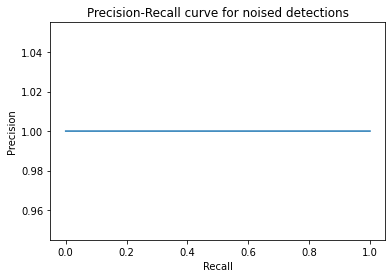

In [52]:
#solution for noisy GT example
rec, prec, ap, tp_Noise, IoU_tp = voc_eval(gt_detect, gt_altered, 0.5, True)

#Calculating mIoU:
def mIoU_calc(IoU_tp):
    mIoU = 0
    mIoUPerFrame = []
    count = 0
    for fr, values in IoU_tp.items():
        mIoU += np.sum(values)
        count += len(values)
        mIoUPerFrame.append(np.mean(values))
    try:
        mIoU /= count
    except:
        mIoU = 0
    return mIoU

print(f'mIoU: {mIoU_calc(IoU_tp)}')

#Calculating mAP:
print(f'mAP: {ap}')

plot_prec_recall_curve(prec, rec, 'Precision-Recall curve for noised detections')

### Testing different stdvs for Resize only

In [51]:
# Testing different standard deviation values (only resize)
stdvs = range(0, 210, 10)
mIoUlist = []
mAPlist = []

for stdv in stdvs:
    gt_altered = gt_altered = add_alterations(gt_detect, applyNoise = True, doResize = True, resizeStdv = stdv)
    rec, prec, ap, tp_Noise, IoU, IoU_tp = voc_eval(gt_detect, gt_altered, 0.5, True)
    mIoUlist.append(mIoU_calc(IoU))
    mAPlist.append(ap)

plt.plot(stdvs, mIoUlist, 'r', label='mIoU')
plt.plot(stdvs, mAPlist, 'b', label='mAP')
plt.xlabel("stdv_w=stdv_h")
plt.legend()
plt.show()

ValueError: not enough values to unpack (expected 6, got 5)

### Testing different stdvs for Displacement only

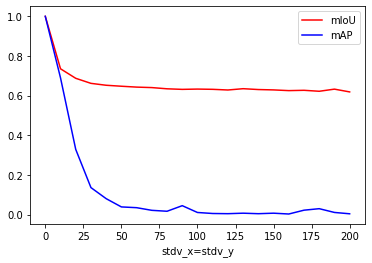

In [31]:
stdvs = range(0, 210, 10)
mIoUlist = []
mAPlist = []

for stdv in stdvs:
    gt_altered = gt_altered = add_alterations(gt_detect, applyNoise = True, doDisplacement = True, displacementStdv = stdv)
    rec, prec, ap, tp_Noise, IoU_tp = voc_eval(gt_detect, gt_altered, 0.5, True)
    mIoUlist.append(mIoU_calc(IoU_tp))
    mAPlist.append(ap)

plt.plot(stdvs, mIoUlist, 'r', label='mIoU')
plt.plot(stdvs, mAPlist, 'b', label='mAP')
plt.xlabel("stdv_x=stdv_y")
plt.legend()
plt.show()

### Testing different probabilities for box Deletion only

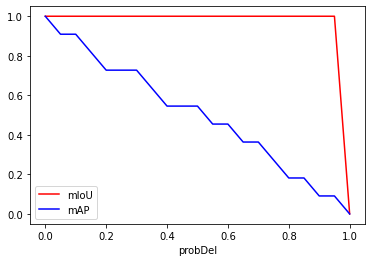

In [48]:
probs = [x * 0.01 for x in range(0, 105, 5)]
mIoUlist = []
mAPlist = []

for prob in probs:
    gt_altered = gt_altered = add_alterations(gt_detect, applyDelgen = True, delProb = prob)
    rec, prec, ap, tp_Noise, IoU_tp = voc_eval(gt_detect, gt_altered, 0.5, True)
    mIoUlist.append(mIoU_calc(IoU_tp))
    mAPlist.append(ap)

plt.plot(probs, mIoUlist, 'r', label='mIoU')
plt.plot(probs, mAPlist, 'b', label='mAP')
plt.xlabel("probDel")
plt.legend()
plt.show()

### Testing different probabilities for box Generation (over existing boxes) only

In [ ]:
probs = [x * 0.01 for x in range(0, 105, 5)]
mIoUlist = []
mAPlist = []

for prob in probs:
    gt_altered = gt_altered = add_alterations(gt_detect, applyDelgen = True, delProb = prob)
    rec, prec, ap, tp_Noise, IoU_tp = voc_eval(gt_detect, gt_altered, 0.5, True)
    mIoUlist.append(mIoU_calc(IoU_tp))
    mAPlist.append(ap)

plt.plot(probs, mIoUlist, 'r', label='mIoU')
plt.plot(probs, mAPlist, 'b', label='mAP')
plt.xlabel("probDel")
plt.legend()
plt.show()

In [ ]:
# generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, gt_altered, 'noised_GT', 250, 255)

## Evaluating mAP for Mask RCNN, SSD512 and Yolo3

In [ ]:
yolo3_dect = readDetections(data_path + 'det/det_yolo3.txt')

In [ ]:
rec, prec, ap, tp_yolo3 = voc_eval(gt_detect, yolo3_dect, 0.5, False)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for yolo3 detections - AP {ap}')

In [ ]:
ssd512_dect = readDetections(data_path + 'det/det_ssd512.txt')

In [ ]:
rec, prec, ap, tp_SSD512 = voc_eval(gt_detect, ssd512_dect, 0.5, True)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for ssd512 detections - AP {ap}')

In [ ]:
mask_rcnn_dect = readDetections(data_path + 'det/det_mask_rcnn.txt')

In [ ]:
rec, prec, ap, tp_mask_rcnn = voc_eval(gt_detect, mask_rcnn_dect, 0.5, True)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for Mask RCNN detections - AP {ap}')

## Multiple random shuffle of predictions for cases without confidence values

In [ ]:
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, yolo3_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
labels = [('Random trial ' + str(i)) for i in range(N)]
plot_multiple_prec_recall_curves(precs, recs, labels)

None vs Confidence vs N shuffles

In [ ]:
#No confidence
rec_nc, prec_nc, ap_nc, _ = voc_eval(gt_detect, yolo3_dect, 0.5, False)

#No confidence but multiple shuffles
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, yolo3_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
precs_array = np.array(precs)
precs_average = np.mean(precs, axis=0)

#Confiedence
rec_c, prec_c, ap_c, _ = voc_eval(gt_detect, yolo3_dect, 0.5, True)


plot_multiple_prec_recall_curves([prec_nc, precs_average, prec_c], recs[0:3], ['No confidence', f'{N}-Shuffle', 'Confidence'], 'YOLO3 Precision comparison')

In [ ]:
#No confidence
rec_nc, prec_nc, ap_nc, _ = voc_eval(gt_detect, ssd512_dect, 0.5, False)

#No confidence but multiple shuffles
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, ssd512_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
precs_array = np.array(precs)
precs_average = np.mean(precs, axis=0)

#Confiedence
rec_c, prec_c, ap_c, _ = voc_eval(gt_detect, ssd512_dect, 0.5, True)


plot_multiple_prec_recall_curves([prec_nc, precs_average, prec_c], recs[0:3], ['No confidence', f'{N}-Shuffle', 'Confidence'], 'YOLO3 Precision comparison')

In [ ]:
# generate_videoBB_comparison(data_path + 'vdo.avi', tp_SSD512, tp_SSD512, 'noised_GT', 1, 500)